In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sklearn
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split,cross_validate, cross_val_score, cross_val_predict
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')


In [28]:
train_df = pd.read_csv('./archive/cbb.csv')
train_df = train_df[train_df['SEED'] < 17.0]
train_df.reset_index()
test_df = pd.read_csv('./archive/cbb21.csv')
test_df[test_df['SEED'] < 17.0]
test_df.reset_index()

y_post = np.array(train_df['POSTSEASON'])
y_post = y_post.reshape(len(y_post),1)
cats = np.array(['Champions', '2ND', 'F4', 'E8', 'S16', 'R32', 'R64', 'R68'][::-1])
cats = list(cats.reshape(1,-1))


onehot = OneHotEncoder(categories=cats, sparse=False)

onehot_encode = onehot.fit_transform(y_post)
y_group=np.array([None]*onehot_encode.shape[0])
for i,row in enumerate(onehot_encode):
    idx = list(np.where(row == 1)[0])
   
    if idx[0] < 2.5:
        y_group[i] = 0
    elif idx[0] > 2.5:
        y_group[i] = 1
        
smote = SMOTE()
x_cats = ['TEAM','ADJOE','ADJDE','EFG_O','EFG_D','TOR', 'TORD', 'ORB','FTRD', '2P_D', '3P_O', '3P_D','ADJ_T']
X = train_df[x_cats]
X_test = test_df[x_cats]
# y-test
sweet_16 = ['Gonzaga', 'Creighton', 'USC', 'Oregon', 'Michigan', 'Florida St.','UCLA','Alabama','Baylor','Villanova','Arkansas','Oral Roberts', 'Loyola Chicago', 'Oregon St.', 'Syracuse','Houston']
index_list = []
for t in sweet_16:
    index_list.append(X_test.loc[X_test['TEAM'] == t].index[0])
sweet_g21 = np.zeros(X_test.shape[0])
sweet_g21[index_list] = 1
y_group = y_group.astype(int)
print(type(y_group),type(sweet_g21))
y1 = np.hstack([y_group,sweet_g21])
#print(y1,sweet_g21)
X1 = pd.concat([X,X_test],axis=0)
#X_test=X_test.set_index('TEAM')
X1=X1.set_index('TEAM')
X, y_even = smote.fit_resample(X1,y1)


X.shape
from sklearn.model_selection import KFold
kfold = KFold(n_splits=8) # there are 8 yearts of data, so splitting by year gives the best representative

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


# Now to try and prove Linear with rbf is best with cross_val_score with linaer SVC and randomforest 

In [29]:
svmr = sklearn.svm.SVC(kernel='rbf')
svml = sklearn.svm.SVC(kernel='linear')
rf = RandomForestClassifier()

In [31]:
pca = PCA(n_components=10)
pca.fit(X)
Xpca = pca.fit_transform(X)
#x_train, x_test, y_train, y_test = train_test_split(X,y_even,test_size=0.1,shuffle=False)

pca.explained_variance_ratio_

array([0.49688983, 0.1986337 , 0.11637009, 0.05650535, 0.04026207,
       0.03343767, 0.02027043, 0.01700514, 0.00971771, 0.00731017])

In [35]:
scores =cross_validate(svmr,Xpca[:,0:3],y_even,scoring=('precision', 'recall'),cv=kfold)
print(np.mean(scores['test_precision']),np.mean(scores['test_recall']))

0.6251849221847446 0.646227359020869


In [34]:
cross_validate(svml,Xpca[:,0:3],y_even,scoring=('precision', 'recall'),cv=kfold)
print(np.mean(scores['test_precision']),np.mean(scores['test_recall']))

0.6302118994636541 0.6736353086436208


In [33]:
cross_validate(rf,Xpca[:,0:3],y_even,scoring=('precision', 'recall'),cv=kfold)
print(np.mean(scores['test_precision']),np.mean(scores['test_recall']))

0.6302118994636541 0.6736353086436208


In [36]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()
cross_validate(mlp,Xpca[:,0:3],y_even,scoring=('precision', 'recall'),cv=kfold)
print(np.mean(scores['test_precision']),np.mean(scores['test_recall']))

0.6251849221847446 0.646227359020869


# Well, this means the type of simple classifier really doesn't matter in this scenario

# Honestly though, this is encouraging. We even see I slight deprecation in the model's efficiency when we add more complex model types. A linear classifier seems to perform the best

# Occams Razor

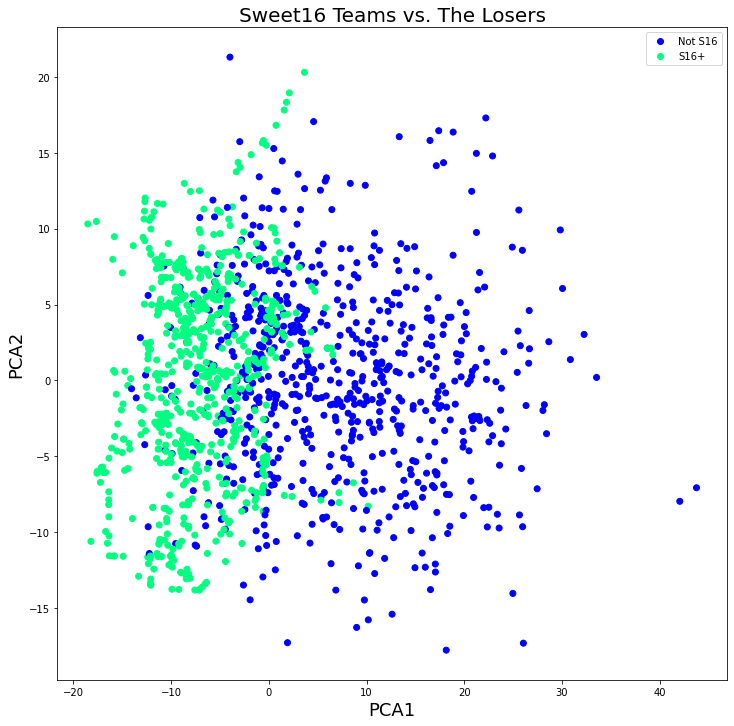

In [37]:
fig=plt.figure(figsize=(12,12))
scat = plt.scatter(Xpca[:,0],Xpca[:,1],c=y_even,cmap='winter')
plt.xlabel('PCA1',fontsize=18)
plt.ylabel('PCA2', fontsize=18)
plt.title('Sweet16 Teams vs. The Losers', fontsize=20)
plt.legend(handles=scat.legend_elements()[0],labels = ['Not S16', 'S16+'])
plt.show()

# In the graph above, we see that in two PCA dimensions (paricularly PCA1), there is a somewhat clear linear classifier, something that a SVC could do. In the codes scattered in the GitHub repo, I tested to see if I couldn't accomplish a simpler task of potentially trying to classify a high-probability sweet 16 team versus one that might have a high-probability of losing before that

## We've identified two sets of training data, one year 13-19 and 21, class imbalanced, and class balanced

## Below we try and test on 2020 Data available to see, and try to get a reasonable output that i can understand (namely, team names)

### Because today is selection sunday 20222!

In [177]:
def precision_recall(y_test, predicted_y):
    tn, fp, fn, tp = confusion_matrix(y_test, predicted_y).ravel()
    precision_score = tp / (tp + fp)
    recall_score = tp / (tp + fn)
    return precision_score, recall_score

In [178]:
svm = sklearn.svm.SVC(kernel='rbf')
y_even = y_even.astype(int)
scores = cross_validate(svm,Xpca[:,0:3],y_even,scoring=('precision', 'recall'),cv=kfold)
scores

{'fit_time': array([0.02366996, 0.03064084, 0.03231001, 0.03438497, 0.02745199,
        0.02472901]),
 'score_time': array([0.01090503, 0.0281353 , 0.01415777, 0.01452804, 0.01690912,
        0.01321697]),
 'test_precision': array([0.30635838, 0.45555556, 0.51219512, 0.97916667, 1.        ,
        1.        ]),
 'test_recall': array([0.94642857, 0.93181818, 0.75      , 0.8952381 , 0.81818182,
        0.79220779])}

In [180]:
svm_split = sklearn.svm.SVC(kernel='rbf')
svm_split.fit(x_train,y_train)
preds = svm_split.predict(x_test)
prec, rec = precision_recall(y_test,preds)

In [181]:
rec

0.8920863309352518

In [172]:
x_test[np.where(preds==1)]

array([[ -9.1667457 ,  -7.61064726,   1.15142503],
       [ -3.18813555,  -7.11215672,  -0.48655957],
       [ -8.41875728,   3.43104233,   6.39982975],
       [ -8.52728618,   7.07533435,   0.58867086],
       [ -4.88682894,  10.5675856 ,  14.08777858],
       [ -5.79632976,   0.28649116,  -6.88291753],
       [ -7.092648  ,  -4.44771517,   0.71804224],
       [ -2.65041344,   0.25311954,  -2.08030475],
       [ -8.56190849, -10.24254002,   3.28435209],
       [-15.87533057,  -5.29760913,  -3.20400766],
       [ -3.83499014,  -2.9891925 ,  -3.11282756],
       [-10.03544919,   7.57622672,   0.31096828],
       [ -1.72425687,  -1.58310368,   5.07892805],
       [ -6.79818109,   6.99347867,  -0.21295461],
       [ -9.27330527,  -0.05047186,  -5.598183  ],
       [ -9.45540432,  -3.27823184,   1.38069011],
       [-11.71852618,   7.78449521,  -1.14009122],
       [ -4.7727914 ,  -1.30713392,  -8.79143556],
       [ -6.28639999,  -0.96323801,  -3.47805985],
       [ -2.23711416,  -2.39703

In [95]:
X_test.iloc[np.where(sweet_g21==1)]

,ADJOE,ADJDE,EFG_O,EFG_D,TOR,TORD,ORB,FTRD,2P_D,3P_O,3P_D,ADJ_T
TEAM,,,,,,,,,,,,
Michigan,118.1,91.1,54.9,44.9,16.3,15.1,29.4,24.5,42.3,38.7,33.5,66.9
Baylor,123.2,94.5,57.5,49.1,17.6,24.6,37.5,31.7,48.1,41.8,34.0,68.8
Gonzaga,125.4,89.8,61.0,47.5,16.1,20.3,30.4,25.9,46.8,36.5,32.5,74.6
Houston,120.6,90.9,51.3,42.9,16.3,21.6,39.4,42.4,43.0,35.5,28.5,65.0
Alabama,111.0,88.1,51.3,45.3,18.6,21.1,31.5,31.9,46.4,35.1,28.8,73.9
Arkansas,110.4,91.2,51.5,47.6,17.4,20.3,31.7,29.3,46.9,33.9,32.6,73.1
Florida St.,117.8,94.0,54.4,46.5,20.1,19.6,35.4,36.3,44.2,39.0,33.3,70.4
Villanova,117.9,96.7,52.8,51.8,13.5,19.0,27.9,25.8,51.0,35.2,35.4,65.1
Creighton,114.4,94.3,55.7,46.9,15.8,17.8,24.8,25.7,46.1,36.7,32.1,69.1


In [167]:
Xpca[2,0:2]

array([-5.14373755, -2.58437968])